In [1]:
!pip install boto3

    100% |################################| 133kB 2.6MB/s 
    100% |################################| 61kB 3.2MB/s 
    100% |################################| 3.5MB 383kB/s 
    100% |################################| 542kB 2.4MB/s 


In [2]:
!pip install seaborn

    100% |################################| 163kB 3.9MB/s 
  Running setup.py bdist_wheel for seaborn ... - done
  Stored in directory: /home/jupyter/.cache/pip/wheels/cb/c8/67/83d615c0ef9b529558525aa521025b183de8c5b156799b091e
Successfully built seaborn


In [3]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve
import random
import time
import itertools
from scipy.stats import mstats

In [4]:
link = 'https://'+os.environ['SECRET_ENV_GITHUB_USERNAME_KEY_JON_N']\
        +':'+os.environ['SECRET_ENV_GITHUB_PASSWORD_KEY_JON_N']\
        +'@github.com/ConstellationBrands/consumer_seg'

In [5]:
!git clone "$link"

Cloning into 'consumer_seg'...
remote: Counting objects: 7, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
Checking connectivity... done.


In [6]:
import sys
sys.path.append('/home/jupyter/consumer_seg')
from S3_helper import S3_helper
from cluster_GridSearch import cluster_GridSearch

In [7]:
import os
access = os.environ['SECRET_ENV_AWS_ACCESS_KEY_JON_N']
secret = os.environ['SECRET_ENV_AWS_SECRET_KEY_JON_N']
bucket = 's3-ds-work-test'
cb_s3 = S3_helper(access,secret,bucket)

In [8]:
cb_s3.pull_file_from_s3('foursquare/cbi_data_4sq_chi.csv','/home/jupyter/cbi_data_4sq_chi.csv')
cb_s3.pull_file_from_s3('foursquare/foursquare_chicago_cbi_matched.csv','/home/jupyter/foursquare_chicago_cbi_matched.csv')

Grabbed foursquare/cbi_data_4sq_chi.csv from S3. Local file /home/jupyter/cbi_data_4sq_chi.csv is now available.
Grabbed foursquare/foursquare_chicago_cbi_matched.csv from S3. Local file /home/jupyter/foursquare_chicago_cbi_matched.csv is now available.


In [9]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

# Data Cleanup

In [10]:
col_dict = {'MKT_CD':str, 'DIST_CD':str, 'TDLINX_STORE_CD':str, 'STORE_CD':str, 'STORE_DSC':str,
       'SOLD_IND':str, 'L30_TY_QTY':float, 'L60_TY_QTY':float, 'L90_TY_QTY':float, 'L365_TY_QTY':float,
       'L12M_TY_QTY:':float, 'L30_LY_QTY':float, 'L60_LY_QTY':float, 'L90_LY_QTY':float,
       'L365_LY_QTY':float, 'L12M_LY_QTY':float, 'LIFETIME_QTY':float, 'FIRST_SOLD_DT':str,
       'LAST_SOLD_DT':str, 'ADDR1':str, 'ADDR2':str, 'CITY':str, 'STATE':str, 'STATE_DSC':str,
       'ZIP':str, 'ZIP5':str, 'COUNTRY_CD':str, 'COUNTRY_DSC':str, 'AREA_CD':str, 'PHONE_NO':str,
       'CONTACT_NM':str, 'PREMISE_TYPE_CD':str, 'SOLD_ACCOUNT_FLG':str, 'CHAIN_FLG':str,
       'ULT_PARENT_CD':str, 'ULT_PARENT_DSC':str, 'CONCEPT_OWNER_CD':str,
       'CONCEPT_OWNER_DSC':str, 'RPT_TO_CD':str, 'RPT_TO_DSC':str, 'IMM_RPT_TO_CD':str,
       'IMM_RPT_TO_DSC':str, 'SUPPLIER_CD':str, 'SUPPLIER_DSC':str, 'STORE_STTS_CD':str,
       'STORE_STTS_DSC':str, 'CHANNEL_CD':str, 'CHANNEL_DSC':str, 'SUBCHANNEL_CD':str,
       'SUBCHANNEL_DSC':str, 'NO_OF_STORES_CD':str, 'NO_OF_STORES_DSC':str,
       'FOOD_TYPE_CD':str, 'FOOD_TYPE_DSC':str, 'ANNUAL_ACV_CD':str, 'ANNUAL_ACV_DSC':str,
       'ANNUAL_ACV_AMT':float, 'NIELSEN_SIZE_CD':str, 'NIELSEN_SIZE_DSC':str,
       'LAT_LONG_PREC_CD':str, 'LAT_LONG_PREC_DSC':str, 'KEY_ACCOUNT_CD':str,
       'KEY_ACCOUNT_DSC':str, 'KEY_ACCT_PREMISE_TYPE_CD':str,
       'KEY_ACCT_PREMISE_TYPE_DSC':str, 'LATITUDE':float, 'LONGITUDE':float,
       'WEEKLY_VOLUME':float, 'SQ_FT':float, 'EMPLOYEE_EQV':float, 'NBR_OF_CHECKOUT':float,
       'NATL_ACCT_GRP_FLG':str, 'CHAIN_IND_FLG':str, 'FRANCHISE_FLG':str, 'GAS_FLG':str,
       'PHARMACY_FLG':str, 'HI_VOL_CIG_FLG':str, 'BEER_FLG':str, 'WINE_FLG':str,
       'LIQUOR_FLG':str, 'FINE_WINE_FLG':str, 'RETAIL_RANK_CD':str, 'RETAIL_RANK_DSC':str,
       'WHITE_POP_PCT':float, 'BLACK_POP_PCT':float, 'ASIAN_POP_PCT':float, 'HISP_POP_PCT':float,
       'LEAST_ACC_HISP_POP_PCT':float, 'BI_CULTURAL_HISP_POP_PCT':float,
       'MOST_ACC_HISP_POP_PCT':float, 'MOST_ACC_HISP_IND':float, 'OTHER_POP_PCT':float,
       'INCOME_POP_L10_PCT':float, 'INCOME_POP_1020_PCT':float, 'INCOME_POP_2030_PCT':float,
       'INCOME_POP_3040_PCT':float, 'INCOME_POP_4050_PCT':float, 'INCOME_POP_5075_PCT':float,
       'INCOME_POP_75100_PCT':float, 'INCOME_POP_G100_PCT':float, 'MALE_POP_2124_PCT':float,
       'MALE_POP_2534_PCT':float, 'MALE_POP_3544_PCT':float, 'MALE_POP_4554_PCT':float,
       'MALE_POP_5564_PCT':float, 'MALE_POP_6574_PCT':float, 'MALE_POP_75_PCT':float,
       'FEMALE_POP_2124_PCT':float, 'FEMALE_POP_2534_PCT':float, 'FEMALE_POP_3544_PCT':float,
       'FEMALE_POP_4554_PCT':float, 'FEMALE_POP_5564_PCT':float, 'FEMALE_POP_6574_PCT':float,
       'FEMALE_POP_75_PCT':float}

In [11]:
data_cbi = pd.read_csv('cbi_data_4sq_chi.csv',dtype=col_dict)
print data_cbi.shape
data_cbi.head()

(10875, 114)


,MKT_CD,DIST_CD,TDLINX_STORE_CD,STORE_CD,STORE_DSC,SOLD_IND,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,FIRST_SOLD_DT,LAST_SOLD_DT,ADDR1,ADDR2,CITY,STATE,STATE_DSC,ZIP,ZIP5,COUNTRY_CD,COUNTRY_DSC,AREA_CD,PHONE_NO,CONTACT_NM,PREMISE_TYPE_CD,SOLD_ACCOUNT_FLG,CHAIN_FLG,ULT_PARENT_CD,ULT_PARENT_DSC,CONCEPT_OWNER_CD,CONCEPT_OWNER_DSC,RPT_TO_CD,RPT_TO_DSC,IMM_RPT_TO_CD,IMM_RPT_TO_DSC,SUPPLIER_CD,SUPPLIER_DSC,STORE_STTS_CD,STORE_STTS_DSC,CHANNEL_CD,CHANNEL_DSC,SUBCHANNEL_CD,SUBCHANNEL_DSC,NO_OF_STORES_CD,NO_OF_STORES_DSC,FOOD_TYPE_CD,FOOD_TYPE_DSC,ANNUAL_ACV_CD,ANNUAL_ACV_DSC,ANNUAL_ACV_AMT,NIELSEN_SIZE_CD,NIELSEN_SIZE_DSC,LAT_LONG_PREC_CD,LAT_LONG_PREC_DSC,KEY_ACCOUNT_CD,KEY_ACCOUNT_DSC,KEY_ACCT_PREMISE_TYPE_CD,KEY_ACCT_PREMISE_TYPE_DSC,LATITUDE,LONGITUDE,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,NATL_ACCT_GRP_FLG,CHAIN_IND_FLG,FRANCHISE_FLG,GAS_FLG,PHARMACY_FLG,HI_VOL_CIG_FLG,BEER_FLG,WINE_FLG,LIQUOR_FLG,FINE_WINE_FLG,RETAIL_RANK_CD,RETAIL_RANK_DSC,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,MOST_ACC_HISP_IND,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,IL,2224764,2062466,102062466,MORTONS THE STEAKHOUSE,Y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,09-SEP-14,15-SEP-14,699 SKOKIE BLVD,NaN,NORTHBROOK,IL,ILLINOIS,600622804,60062,USA,UNITED STATES OF AMERICA,847,9230030,UNKNOWN STORE CONTACT,O,N,NaN,107299,LANDRYS INC,107299,LANDRYS INC,115827,LANDRYS/RESTAURANTS,888888,SMALL SUPPLIER,112813,MORTONS THE STEAKHOUSE,O,OPEN STORE,50,DINING,50*1,FINE DINING,J,201-500 STORES,20,STEAK,UNK,UNKNOWN,0.0,A,URBAN (LARGEST 21 METROS),A,GEOCODED TO SPECIFIC ADDRESS,1292004,ON PREMISE,ON,ON PREMISE,42.1398,-87.7927,0.0,0.0,0.0,0.0,NaN,Y,N,N,N,N,Y,Y,Y,N,NaN,NaN,0.8809,0.0093,0.0724,0.0297,0.0051,0.0095,0.0152,21.0,0.0071,0.0179,0.0251,0.0405,0.0482,0.0464,0.0815,0.0848,0.6554,0.0272,0.0347,0.0323,0.0677,0.0798,0.0560,0.0493,0.0267,0.0331,0.0374,0.0778,0.0868,0.0661,0.0621
1,IL,2224562,1924376,101924376,CRYSTAL LAKE FOOD & LIQUOR,Y,38.4999,88.2775,125.0830,855.9157,857.9157,75.9166,120.2499,154.4998,859.9990,848.6657,3010.3301,02-JAN-13,31-MAR-17,540 E TERRA COTTA AVE,NaN,CRYSTAL LAKE,IL,ILLINOIS,600143652,60014,USA,UNITED STATES OF AMERICA,815,4773600,UNKNOWN STORE CONTACT,F,N,NaN,999999,INDEPENDENT,999999,INDEPENDENT,999999,INDEPENDENT,888888,SMALL SUPPLIER,098647,MISKA LIQUORS,O,OPEN STORE,02,LIQUOR,02*2,CONVENTIONAL LIQUOR,A,1 STORE,UNK,UNKNOWN,02,"$500,001 TO $1,000,000",1000000.0,A,URBAN (LARGEST 21 METROS),A,GEOCODED TO SPECIFIC ADDRESS,1292005,OTHER,OTHER,OTHER,42.2487,-88.3002,15.0,3.0,0.0,0.0,NaN,Y,Y,N,N,N,Y,Y,Y,N,NaN,NaN,0.8691,0.0100,0.0233,0.0886,0.0125,0.0271,0.0490,67.0,0.0082,0.0230,0.0393,0.0538,0.0576,0.0522,0.1462,0.1323,0.4956,0.0300,0.0563,0.0521,0.0790,0.0792,0.0444,0.0207,0.0286,0.0507,0.0515,0.0848,0.0816,0.0457,0.0302
2,IL,2225231,5008890,305008890,REFUGE LIVE,Y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,01-OCT-14,01-OCT-14,416 S CLARK ST,NaN,CHICAGO,IL,ILLINOIS,606051022,60605,USA,UNITED STATES OF AMERICA,312,3851111,UNKNOWN STORE CONTACT,O,N,NaN,999999,INDEPENDENT,999999,INDEPENDENT,999999,INDEPENDENT,888888,SMALL SUPPLIER,555555,NO GROUP ASSIGNMENT,O,OPEN STORE,53,RECREATION,53*9,OTHER ENTERTAINMENT,A,1 STORE,UNK,UNKNOWN,UNK,UNKNOWN,0.0,A,URBAN (LARGEST 21 METROS),A,GEOCODED TO SPECIFIC ADDRESS,1292004,ON PREMISE,NaN,NaN,41.8766,-87.6309,0.0,0.0,0.0,0.0,NaN,N,N,N,N,N,Y,Y,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [12]:
data_4sq = pd.read_csv('foursquare_chicago_cbi_matched.csv',dtype={'constellationid':str},na_values='\N')
print data_4sq.shape
data_4sq.head()

(30446, 168)


,constellationid,venueid,venuename,streetaddress,city,state,postalcode,countrycode,latitude,longitude,chainid,chainname,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday,hourofday_percent_0to2_monday,hourofday_percent_2to4_monday,hourofday_percent_4to6_monday,hourofday_percent_6to8_monday,hourofday_percent_8to10_monday,hourofday_percent_10to12_monday,hourofday_percent_12to14_monday,hourofday_percent_14to16_monday,hourofday_percent_16to18_monday,hourofday_percent_18to20_monday,hourofday_percent_20to22_monday,hourofday_percent_22to24_monday,hourofday_percent_0to2_tuesday,hourofday_percent_2to4_tuesday,hourofday_percent_4to6_tuesday,hourofday_percent_6to8_tuesday,hourofday_percent_8to10_tuesday,hourofday_percent_10to12_tuesday,hourofday_percent_12to14_tuesday,hourofday_percent_14to16_tuesday,hourofday_percent_16to18_tuesday,hourofday_percent_18to20_tuesday,hourofday_percent_20to22_tuesday,hourofday_percent_22to24_tuesday,hourofday_percent_0to2_wednesday,hourofday_percent_2to4_wednesday,hourofday_percent_4to6_wednesday,hourofday_percent_6to8_wednesday,hourofday_percent_8to10_wednesday,hourofday_percent_10to12_wednesday,hourofday_percent_12to14_wednesday,hourofday_percent_14to16_wednesday,hourofday_percent_16to18_wednesday,hourofday_percent_18to20_wednesday,hourofday_percent_20to22_wednesday,hourofday_percent_22to24_wednesday,hourofday_percent_0to2_thursday,hourofday_percent_2to4_thursday,hourofday_percent_4to6_thursday,hourofday_percent_6to8_thursday,hourofday_percent_8to10_thursday,hourofday_percent_10to12_thursday,hourofday_percent_12to14_thursday,hourofday_percent_14to16_thursday,hourofday_percent_16to18_thursday,hourofday_percent_18to20_thursday,hourofday_percent_20to22_thursday,hourofday_percent_22to24_thursday,hourofday_percent_0to2_friday,hourofday_percent_2to4_friday,hourofday_percent_4to6_friday,hourofday_percent_6to8_friday,hourofday_percent_8to10_friday,hourofday_percent_10to12_friday,hourofday_percent_12to14_friday,hourofday_percent_14to16_friday,hourofday_percent_16to18_friday,hourofday_percent_18to20_friday,hourofday_percent_20to22_friday,hourofday_percent_22to24_friday,hourofday_percent_0to2_saturday,hourofday_percent_2to4_saturday,hourofday_percent_4to6_saturday,hourofday_percent_6to8_saturday,hourofday_percent_8to10_saturday,hourofday_percent_10to12_saturday,hourofday_percent_12to14_saturday,hourofday_percent_14to16_saturday,hourofday_percent_16to18_saturday,hourofday_percent_18to20_saturday,hourofday_percent_20to22_saturday,hourofday_percent_22to24_saturday,hourofday_percent_0to2_sunday,hourofday_percent_2to4_sunday,hourofday_percent_4to6_sunday,hourofday_percent_6to8_sunday,hourofday_percent_8to10_sunday,hourofday_percent_10to12_sunday,hourofday_percent_12to14_sunday,hourofday_percent_14to16_sunday,hourofday_percent_16to18_sunday,hourofday_percent_18to20_sunday,hourofday_percent_20to22_sunday,hourofday_percent_22to24_sunday,drinks_cocktails,drinks_beer,drinks_wine,drinks_serveshappyhour,category,category_level1,category_level2,category_level3,taste1,taste2,taste3,taste4,taste5,taste6,taste7,taste8,taste9,taste10,taste1_score,taste2_score,taste3_score,taste4_score,taste5_score,taste6_score,taste7_score,taste8_score,taste9_score,taste10_score,venuebefore1,venuebefore2,venuebefore3,venuebefore4,venuebefore5,venuebefore6,venuebefore7,venuebefore8,venuebefore9,venuebefore10,venueafter1,venueafter2,venueafter3,venueafter4,venueafter5,venueafter6,venueafter7,venueafter8,venueafter9,venueafter10,opendate,closedate
0,5031219,40b28c80f964a52001fc1ee3,

In [13]:
data_join = data_cbi.merge(data_4sq,how='left',left_on='TDLINX_STORE_CD',right_on='constellationid')
print data_join.shape
data_join.head()

(10875, 282)


,MKT_CD,DIST_CD,TDLINX_STORE_CD,STORE_CD,STORE_DSC,SOLD_IND,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,FIRST_SOLD_DT,LAST_SOLD_DT,ADDR1,ADDR2,CITY,STATE,STATE_DSC,ZIP,ZIP5,COUNTRY_CD,COUNTRY_DSC,AREA_CD,PHONE_NO,CONTACT_NM,PREMISE_TYPE_CD,SOLD_ACCOUNT_FLG,CHAIN_FLG,ULT_PARENT_CD,ULT_PARENT_DSC,CONCEPT_OWNER_CD,CONCEPT_OWNER_DSC,RPT_TO_CD,RPT_TO_DSC,IMM_RPT_TO_CD,IMM_RPT_TO_DSC,SUPPLIER_CD,SUPPLIER_DSC,STORE_STTS_CD,STORE_STTS_DSC,CHANNEL_CD,CHANNEL_DSC,SUBCHANNEL_CD,SUBCHANNEL_DSC,NO_OF_STORES_CD,NO_OF_STORES_DSC,FOOD_TYPE_CD,FOOD_TYPE_DSC,ANNUAL_ACV_CD,ANNUAL_ACV_DSC,ANNUAL_ACV_AMT,NIELSEN_SIZE_CD,NIELSEN_SIZE_DSC,LAT_LONG_PREC_CD,LAT_LONG_PREC_DSC,KEY_ACCOUNT_CD,KEY_ACCOUNT_DSC,KEY_ACCT_PREMISE_TYPE_CD,KEY_ACCT_PREMISE_TYPE_DSC,LATITUDE,LONGITUDE,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,NATL_ACCT_GRP_FLG,CHAIN_IND_FLG,FRANCHISE_FLG,GAS_FLG,PHARMACY_FLG,HI_VOL_CIG_FLG,BEER_FLG,WINE_FLG,LIQUOR_FLG,FINE_WINE_FLG,RETAIL_RANK_CD,RETAIL_RANK_DSC,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,MOST_ACC_HISP_IND,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,constellationid,venueid,venuename,streetaddress,city,state,postalcode,countrycode,latitude,longitude,chainid,chainname,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday,hourofday_percent_0to2_monday,hourofday_percent_2to4_monday,hourofday_percent_4to6_monday,hourofday_percent_6to8_monday,hourofday_percent_8to10_monday,hourofday_percent_10to12_monday,hourofday_percent_12to14_monday,hourofday_percent_14to16_monday,hourofday_percent_16to18_monday,hourofday_percent_18to20_monday,hourofday_percent_20to22_monday,hourofday_percent_22to24_monday,hourofday_percent_0to2_tuesday,hourofday_percent_2to4_tuesday,hourofday_percent_4to6_tuesday,hourofday_percent_6to8_tuesday,hourofday_percent_8to10_tuesday,hourofday_percent_10to12_tuesday,hourofday_percent_12to14_tuesday,hourofday_percent_14to16_tuesday,hourofday_percent_16to18_tuesday,hourofday_percent_18to20_tuesday,hourofday_percent_20to22_tuesday,hourofday_percent_22to24_tuesday,hourofday_percent_0to2_wednesday,hourofday_percent_2to4_wednesday,hourofday_percent_4to6_wednesday,hourofday_percent_6to8_wednesday,hourofday_percent_8to10_wednesday,hourofday_percent_10to12_wednesday,hourofday_percent_12to14_wednesday,hourofday_percent_14to16_wednesday,hourofday_percent_16to18_wednesday,hourofday_percent_18to20_wednesday,hourofday_percent_20to22_wednesday,hourofday_percent_22to24_wednesday,hourofday_percent_0to2_thursday,hourofday_percent_2to4_thursday,hourofday_percent_4to6_thursday,hourofday_percent_6to8_thursday,hourofday_percent_8to10_thursday,hourofday_percent_10to12_thursday,hourofday_percent_12to14_thursday,hourofday_percent_14to16_thursday,hourofday_percent_16to18_thursday,hourofday_percent_18to20_thursday,hourofday_percent_20to22_thursday,hourofday_percent_22to24_thursday,hourofday_percent_0to2_friday,hourofday_percent_2to4_friday,hourofday_percent_4to6_friday,hourofday_percent_6to8_friday,hourofday_percent_8to10_friday,h

In [14]:
keep_cbi = ['PREMISE_TYPE_CD','CHANNEL_DSC','TDLINX_STORE_CD','SOLD_IND', 'L30_TY_QTY', 'L60_TY_QTY', 'L90_TY_QTY', 
            'L365_TY_QTY','L12M_TY_QTY', 'L30_LY_QTY', 'L60_LY_QTY', 'L90_LY_QTY','L365_LY_QTY', 'L12M_LY_QTY', 
            'LIFETIME_QTY','NO_OF_STORES_DSC','ANNUAL_ACV_DSC','NIELSEN_SIZE_DSC','WEEKLY_VOLUME', 'SQ_FT', 
            'EMPLOYEE_EQV', 'NBR_OF_CHECKOUT','WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT', 'HISP_POP_PCT',
            'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT','MOST_ACC_HISP_POP_PCT',  
            'OTHER_POP_PCT','INCOME_POP_L10_PCT', 'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT','INCOME_POP_3040_PCT', 
            'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT','INCOME_POP_75100_PCT', 'INCOME_POP_G100_PCT', 
            'MALE_POP_2124_PCT','MALE_POP_2534_PCT', 'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT','MALE_POP_5564_PCT', 
            'MALE_POP_6574_PCT', 'MALE_POP_75_PCT','FEMALE_POP_2124_PCT', 'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT',
            'FEMALE_POP_4554_PCT', 'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT','FEMALE_POP_75_PCT'] 

keep_4sq = ['rating','last1_month_visits_normalized', 'last2_month_visits_normalized','last3_month_visits_normalized', 
            'last4_month_visits_normalized','last5_month_visits_normalized', 'last6_month_visits_normalized',
            'gender_percent_male', 'gender_percent_female','age_percent_lessthan18', 'age_percent_18to24',
            'age_percent_25to34', 'age_percent_35to44', 'age_percent_45to54','age_percent_55plus', 'dayofweek_percent_monday',
            'dayofweek_percent_tuesday', 'dayofweek_percent_wednesday','dayofweek_percent_thursday', 'dayofweek_percent_friday',
            'dayofweek_percent_saturday', 'dayofweek_percent_sunday','drinks_cocktails','drinks_beer', 'drinks_wine', 
            'drinks_serveshappyhour']

keep_all = keep_cbi+keep_4sq

In [15]:
data_join = data_join[keep_all]

In [16]:
#Convert values with % to float
col_chg = ['gender_percent_male','gender_percent_female','age_percent_lessthan18','age_percent_18to24','age_percent_25to34','age_percent_35to44',
           'age_percent_45to54','age_percent_55plus','dayofweek_percent_monday','dayofweek_percent_tuesday','dayofweek_percent_wednesday',
           'dayofweek_percent_thursday','dayofweek_percent_friday','dayofweek_percent_saturday','dayofweek_percent_sunday']

for col in col_chg:
    data_join[col] = pd.to_numeric(data_join[col].map(lambda x: str(x).rstrip('%')),errors='coerce')/100

In [17]:
data_join.describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday
count,8433.000000,8433.000000,8433.000000,8433.000000,8433.000000,8433.000000,8433.000000,8433.000000,8433.00000,8433.000000,8433.000000,10875.000000,10875.000000,10875.000000,10875.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9637.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.00000,9327.000000
mean,60.053368,116.082704,156.383308,857.771975,857.891535,57.990431,105.196773,144.018936,786.00337,785.693358,3140.091016,53.638621,3.969747,6.191908,0.699310,0.627501,0.099755,0.084793,0.174269,0.033316,0.060584,0.080368,0.012647,0.046963,0.060819,0.069414,0.072467,0.071739,0.166640,0.135527,0.376430,0.023974,0.082212,0.071600,0.066458,0.059602,0.037263,0.021506,0.024606,0.084040,0.071449,0.067760,0.064188,0.043177,0.032654,5.348365,177.653680,175.649333,170.971259,178.018784,187.603016,198.106169,0.400199,0.287991,0.001499,0.039185,0.228786,0.187933,0.115212,0.064011,0.107825,0.117468,0.118872,0.126381,0.174381,0.21486,0.140876
std,188.649426,358.528653,486.452359,2771.662591,2773.275433,198.552175,354.121757,475.069083,2769.68071,2767.751567,11221.524397,211.878233,17.187524,39.713833,3.303633,0.204181,0.148791,0.071679,0.150427,0.032905,0.056379,0.065029,0.004848,0.028090,0.025278,0.025302,0.022139,0.019064,0.030129,0.021155,0.120949,0.006709,0.035782,0.015418,0.006892,0.012061,0.008705,0.007884,0.005956,0.040029,0.012304,0.008744,0.014038,0.010694,0.012836,3.428258,1320.851947,1228.285675,1254.579365,1313.715251,1410.014716,1555.480295,0.191738,0.176093,0.009391,0.072922,0.171508,0.151745,0.138304,0.107663,0.090856,0.096630,0.094049,0.103226,0.116993,0.14126,0.109762
min,-87.333400,-1.000000,-5.333300,0.000000,0.000000,0.000000,0.000000,-127.333300,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006500,0.000300,0.000700,0.012300,0.002600,0.003900,0.004800,0.001700,0.001200,0.008200,0.012000,0.019800,0.022500,0.049000,0.042400,0.067300,0.007000,0.024100,0.024000,0.029300,0.025200,0.015600,0.005500,0.008600,0.027400,0.029600,0.028800,0.026800,0.017000,0.007100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,

# Missing Values

In [18]:
data_join[keep_all].isnull().sum()

PREMISE_TYPE_CD                     0
CHANNEL_DSC                         0
TDLINX_STORE_CD                     0
SOLD_IND                            0
L30_TY_QTY                       2442
L60_TY_QTY                       2442
L90_TY_QTY                       2442
L365_TY_QTY                      2442
L12M_TY_QTY                      2442
L30_LY_QTY                       2442
L60_LY_QTY                       2442
L90_LY_QTY                       2442
L365_LY_QTY                      2442
L12M_LY_QTY                      2442
LIFETIME_QTY                     2442
NO_OF_STORES_DSC                    0
ANNUAL_ACV_DSC                      0
NIELSEN_SIZE_DSC                    0
WEEKLY_VOLUME                       0
SQ_FT                               0
EMPLOYEE_EQV                        0
NBR_OF_CHECKOUT                     0
WHITE_POP_PCT                    1238
BLACK_POP_PCT                    1238
ASIAN_POP_PCT                    1238
HISP_POP_PCT                     1238
LEAST_ACC_HI

In [19]:
#Remove missing values for now
data_cleaned = data_join.dropna(axis=0, how='any')
print data_cleaned.shape

(6233, 78)


In [20]:
data_on = data_cleaned[data_cleaned['PREMISE_TYPE_CD']=='O']
data_on.describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.0,4989.0,4989.0,4989.0,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,14.785191,28.303789,38.932949,176.201421,176.030701,13.545035,25.182333,35.387865,158.569847,158.856567,641.905206,0.0,0.0,0.0,0.0,0.632472,0.090579,0.084659,0.178725,0.033827,0.062253,0.082646,0.012526,0.046271,0.060866,0.069587,0.072831,0.072115,0.167393,0.135748,0.375189,0.023807,0.082784,0.072048,0.066501,0.059564,0.037231,0.021540,0.024449,0.084526,0.071629,0.067504,0.063974,0.043090,0.032887,5.809501,138.109504,133.550250,130.394349,131.598685,143.671260,154.817893,0.397871,0.283478,0.001453,0.039583,0.227615,0.186162,0.113969,0.063923,0.104360,0.116372,0.117949,0.125346,0.179651,0.217623,0.139280
std,33.311548,63.415394,86.372695,375.803863,375.406764,32.036619,59.523536,82.524548,349.932724,350.981010,1349.660801,0.0,0.0,0.0,0.0,0.194357,0.126153,0.073621,0.151013,0.032173,0.056789,0.065858,0.004760,0.025261,0.023373,0.024217,0.021748,0.018864,0.029967,0.020040,0.116626,0.006488,0.036134,0.015157,0.006518,0.011865,0.008416,0.007809,0.005568,0.040404,0.012061,0.008590,0.013962,0.010407,0.013089,3.178435,262.384445,239.297986,225.476749,248.655497,279.280011,321.880418,0.176480,0.158361,0.008959,0.067948,0.161071,0.136377,0.126684,0.097298,0.083446,0.087510,0.083087,0.088765,0.106862,0.128528,0.096506
min,-8.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.006500,0.002800,0.000900,0.012300,0.002800,0.003900,0.004800,0.001700,0.002500,0.008200,0.018500,0.022500,0.022500,0.049300,0.042700,0.067300,0.007000,0.030500,0.024400,0.036300,0.033000,0.015900,0.005800,0.011700,0.029300,0.029600,0.035900,0.026800,0.019400,0.008900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,14.000000,14.000000,0.000000,0.000000,1.000000,12.000000,12.000000,66.000000,0.0,0.0,0.0,0

In [21]:
def drop_columns(data):
    for col in data.columns.values:
        if data[col].dtypes!='O' and sum(data[col]==0)==len(data[col]):
            data = data.drop(col,axis=1)
    return data

In [22]:
data_on = drop_columns(data_on)
data_on.describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,14.785191,28.303789,38.932949,176.201421,176.030701,13.545035,25.182333,35.387865,158.569847,158.856567,641.905206,0.632472,0.090579,0.084659,0.178725,0.033827,0.062253,0.082646,0.012526,0.046271,0.060866,0.069587,0.072831,0.072115,0.167393,0.135748,0.375189,0.023807,0.082784,0.072048,0.066501,0.059564,0.037231,0.021540,0.024449,0.084526,0.071629,0.067504,0.063974,0.043090,0.032887,5.809501,138.109504,133.550250,130.394349,131.598685,143.671260,154.817893,0.397871,0.283478,0.001453,0.039583,0.227615,0.186162,0.113969,0.063923,0.104360,0.116372,0.117949,0.125346,0.179651,0.217623,0.139280
std,33.311548,63.415394,86.372695,375.803863,375.406764,32.036619,59.523536,82.524548,349.932724,350.981010,1349.660801,0.194357,0.126153,0.073621,0.151013,0.032173,0.056789,0.065858,0.004760,0.025261,0.023373,0.024217,0.021748,0.018864,0.029967,0.020040,0.116626,0.006488,0.036134,0.015157,0.006518,0.011865,0.008416,0.007809,0.005568,0.040404,0.012061,0.008590,0.013962,0.010407,0.013089,3.178435,262.384445,239.297986,225.476749,248.655497,279.280011,321.880418,0.176480,0.158361,0.008959,0.067948,0.161071,0.136377,0.126684,0.097298,0.083446,0.087510,0.083087,0.088765,0.106862,0.128528,0.096506
min,-8.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006500,0.002800,0.000900,0.012300,0.002800,0.003900,0.004800,0.001700,0.002500,0.008200,0.018500,0.022500,0.022500,0.049300,0.042700,0.067300,0.007000,0.030500,0.024400,0.036300,0.033000,0.015900,0.005800,0.011700,0.029300,0.029600,0.035900,0.026800,0.019400,0.008900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,14.000000,14.000000,0.000000,0.000000,1.000000,12.000000,12.000000,66.000000,0.520300,0.022900,0.030200,0.073000,0.013900,0.022200,0.035700,0.008800,0.026500,0.043500,0.049400,0.055000,0.058100,0.144500,0.122500,0.2

In [23]:
data_off = data_cleaned[data_cleaned['PREMISE_TYPE_CD']=='F']
data_off.describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.00000,1244.000000,1244.000000,1244.000000
mean,153.303593,293.457423,393.957852,2235.559441,2236.120735,149.162656,269.240888,363.215445,2037.406927,2035.868454,8110.108186,193.971061,13.957395,22.894695,2.346463,0.607504,0.123927,0.075342,0.180232,0.034336,0.062441,0.083452,0.011937,0.045746,0.061467,0.071002,0.073950,0.072710,0.169105,0.137721,0.368296,0.025287,0.075157,0.068887,0.067004,0.060843,0.037524,0.021513,0.025277,0.076085,0.069843,0.069270,0.065646,0.043674,0.032458,4.537942,246.246815,258.398694,258.126488,285.438988,269.757821,254.012285,0.389003,0.286584,0.000876,0.037902,0.207765,0.198738,0.121801,0.067170,0.122170,0.123312,0.124494,0.12836,0.170659,0.191141,0.140370
std,325.842774,616.096313,820.626791,4572.740341,4576.860767,342.316727,628.469411,824.657808,4670.857103,4662.720793,19091.033567,412.040291,25.954424,83.045031,6.549992,0.229631,0.190926,0.064329,0.157411,0.035936,0.058193,0.067226,0.004592,0.031371,0.028880,0.027506,0.023124,0.019573,0.028152,0.022628,0.126905,0.007465,0.029918,0.013971,0.007756,0.011869,0.009204,0.007961,0.007386,0.032401,0.011438,0.008884,0.013405,0.011193,0.012311,3.456589,685.956802,694.329915,692.098107,1025.636650,832.042516,693.455062,0.224483,0.201904,0.004621,0.088272,0.189077,0.186962,0.155137,0.125056,0.103918,0.110356,0.104873,0.11608,0.155839,0.160558,0.125429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.041200,0.002600,0.000700,0.018900,0.003000,0.006700,0.006800,0.002500,0.001200,0.008700,0.012000,0.019800,0.027500,0.082400,0.069600,0.086000,0.007300,0.029800,0.027800,0.029300,0.025200,0.015600,0.005500,0.008600,0.027900,0.032000,0.028800,0.027100,0.017000,0.008100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,18.000000,34

In [24]:
data_off = drop_columns(data_off)
data_off.describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.00000,1244.000000,1244.000000,1244.000000
mean,153.303593,293.457423,393.957852,2235.559441,2236.120735,149.162656,269.240888,363.215445,2037.406927,2035.868454,8110.108186,193.971061,13.957395,22.894695,2.346463,0.607504,0.123927,0.075342,0.180232,0.034336,0.062441,0.083452,0.011937,0.045746,0.061467,0.071002,0.073950,0.072710,0.169105,0.137721,0.368296,0.025287,0.075157,0.068887,0.067004,0.060843,0.037524,0.021513,0.025277,0.076085,0.069843,0.069270,0.065646,0.043674,0.032458,4.537942,246.246815,258.398694,258.126488,285.438988,269.757821,254.012285,0.389003,0.286584,0.000876,0.037902,0.207765,0.198738,0.121801,0.067170,0.122170,0.123312,0.124494,0.12836,0.170659,0.191141,0.140370
std,325.842774,616.096313,820.626791,4572.740341,4576.860767,342.316727,628.469411,824.657808,4670.857103,4662.720793,19091.033567,412.040291,25.954424,83.045031,6.549992,0.229631,0.190926,0.064329,0.157411,0.035936,0.058193,0.067226,0.004592,0.031371,0.028880,0.027506,0.023124,0.019573,0.028152,0.022628,0.126905,0.007465,0.029918,0.013971,0.007756,0.011869,0.009204,0.007961,0.007386,0.032401,0.011438,0.008884,0.013405,0.011193,0.012311,3.456589,685.956802,694.329915,692.098107,1025.636650,832.042516,693.455062,0.224483,0.201904,0.004621,0.088272,0.189077,0.186962,0.155137,0.125056,0.103918,0.110356,0.104873,0.11608,0.155839,0.160558,0.125429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.041200,0.002600,0.000700,0.018900,0.003000,0.006700,0.006800,0.002500,0.001200,0.008700,0.012000,0.019800,0.027500,0.082400,0.069600,0.086000,0.007300,0.029800,0.027800,0.029300,0.025200,0.015600,0.005500,0.008600,0.027900,0.032000,0.028800,0.027100,0.017000,0.008100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,18.000000,34

# Convert Columns to Dummy Variables

In [25]:
def dummy_convert(data, cols):
    return pd.concat([data ,pd.get_dummies(data[cols], prefix = ['B_'+c for c in cols])] , axis = 1)

In [26]:
for col in data_on.columns.values:
    if data_on[col].dtype=='O':
        print col

PREMISE_TYPE_CD
CHANNEL_DSC
TDLINX_STORE_CD
SOLD_IND
NO_OF_STORES_DSC
ANNUAL_ACV_DSC
NIELSEN_SIZE_DSC
drinks_cocktails
drinks_beer
drinks_wine
drinks_serveshappyhour


In [27]:
columns = ['CHANNEL_DSC','NO_OF_STORES_DSC','ANNUAL_ACV_DSC','NIELSEN_SIZE_DSC','drinks_cocktails','drinks_beer','drinks_wine','drinks_serveshappyhour']
for col in columns:
    print col
    print data_on[col].value_counts(normalize=True)
    print

CHANNEL_DSC
DINING                        0.643015
BAR/NIGHTCLUB                 0.313289
LODGING                       0.041692
RECREATION                    0.001804
EXTENDED MASTER ON-PREMISE    0.000200
Name: CHANNEL_DSC, dtype: float64

NO_OF_STORES_DSC
1 STORE           0.818801
501+ STORES       0.040088
51-100 STORES     0.024053
6-10 STORES       0.023251
201-500 STORES    0.022850
26-50 STORES      0.022650
11-25 STORES      0.022449
101-200 STORES    0.018641
4-5 STORES        0.005612
2-3 STORES        0.001604
Name: NO_OF_STORES_DSC, dtype: float64

ANNUAL_ACV_DSC
UNKNOWN    1.0
Name: ANNUAL_ACV_DSC, dtype: float64

NIELSEN_SIZE_DSC
URBAN (LARGEST 21 METROS)    0.976749
20K=85K HOUSEHOLDS           0.023051
URBAN ALL OTHER COUNTIES     0.000200
Name: NIELSEN_SIZE_DSC, dtype: float64

drinks_cocktails
f    0.642012
t    0.357988
Name: drinks_cocktails, dtype: float64

drinks_beer
f    0.688314
t    0.311686
Name: drinks_beer, dtype: float64

drinks_wine
f    0.894568
t    0

In [28]:
#drop infrequent columns
data_on = data_on.drop('ANNUAL_ACV_DSC',axis=1)

In [29]:
# Need to add SOLD_IND later when including unsolds 
columns = ['CHANNEL_DSC','NO_OF_STORES_DSC','NIELSEN_SIZE_DSC','drinks_cocktails','drinks_beer','drinks_wine','drinks_serveshappyhour']
data_on = dummy_convert(data_on,columns)

In [30]:
data_on.head()

,PREMISE_TYPE_CD,CHANNEL_DSC,TDLINX_STORE_CD,SOLD_IND,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,NO_OF_STORES_DSC,NIELSEN_SIZE_DSC,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday,drinks_cocktails,drinks_beer,drinks_wine,drinks_serveshappyhour,B_CHANNEL_DSC_BAR/NIGHTCLUB,B_CHANNEL_DSC_DINING,B_CHANNEL_DSC_EXTENDED MASTER ON-PREMISE,B_CHANNEL_DSC_LODGING,B_CHANNEL_DSC_RECREATION,B_NO_OF_STORES_DSC_1 STORE,B_NO_OF_STORES_DSC_101-200 STORES,B_NO_OF_STORES_DSC_11-25 STORES,B_NO_OF_STORES_DSC_2-3 STORES,B_NO_OF_STORES_DSC_201-500 STORES,B_NO_OF_STORES_DSC_26-50 STORES,B_NO_OF_STORES_DSC_4-5 STORES,B_NO_OF_STORES_DSC_501+ STORES,B_NO_OF_STORES_DSC_51-100 STORES,B_NO_OF_STORES_DSC_6-10 STORES,B_NIELSEN_SIZE_DSC_20K=85K HOUSEHOLDS,B_NIELSEN_SIZE_DSC_URBAN (LARGEST 21 METROS),B_NIELSEN_SIZE_DSC_URBAN ALL OTHER COUNTIES,B_drinks_cocktails_f,B_drinks_cocktails_t,B_drinks_beer_f,B_drinks_beer_t,B_drinks_wine_f,B_drinks_wine_t,B_drinks_serveshappyhour_f,B_drinks_serveshappyhour_t
0,O,DINING,2062466,Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201-500 STORES,URBAN (LARGEST 21 METROS),0.8809,0.0093,0.0724,0.0297,0.0051,0.0095,0.0152,0.0071,0.0179,0.0251,0.0405,0.0482,0.0464,0.0815,0.0848,0.6554,0.0272,0.0347,0.0323,0.0677,0.0798,0.0560,0.0493,0.0267,0.0331,0.0374,0.0778,0.0868,0.0661,0.0621,8.4,79.88100,123.97101,110.53396,101.60949,74.43658,82.49736,0.50,0.16,0.0,0.01,0.07,0.09,0.39,0.01,0.16,0.17,0.17,0.17,0.16,0.11,0.07,f,f,f,f,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
4,O,BAR/NIGHTCLUB,1402610,Y,9.0,16.0,27.0,142.0,139.0,17.0,33.0,46.0,189.0,192.0,677.0,1 STORE,URBAN (LARGEST 21 METROS),0.5649,0.1287,0.1367,0.1475,0.0448,0.0452,0.0575,0.0206,0.0922,0.1072,0.1013,0.0988,0.0908,0.1617,0.1148,0.2332,0.0192,0.0983,0.0964,0.0789,0.0609,0.0352,0.0185,0.0224,0.0949,0.0844,0.0633,0.0563,0.0397,0.0284,6.3,16.81705,39.84782,40.93851,19.54029,33.49646,49.49842,0.33,0.38,0.0,0.09,0.26,0.26,0.09,0.00,0.14,0.05,0.10,0.05,0.26,0.22,0.17,t,t,f,f,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0
5,O,BAR/NIGHTCLUB,1743697,Y,0.0,1.0,1.0,6.0,6.0,0.0,1.0,1.0,3.0,3.0,16.0,1 STORE,URBAN (LARGEST 21 METROS),0.0341,0.9227,0.0021,0.0272,0.0061,0.0096,0.0116,0.0121,0.1092,0.1321,0.1305,0.1039,0.0898,0.1776,0.1035,0.1534,0.0294,0.0614,0.0499,0.0539,0.0555,0.0357,0.0251,0.0303,0.0725,0.0653,0.0698,0.0748,0.0563,0.0436,0.0,79.88100,101.83333,53.22006,50.80475,78.15841,72.59768,0.39,0.23,0.0,0.04,0.07,0.37,0.09,0.04,0.21,0.10,0.09,0.10,0.21,0.17,0.11,f,f,f,f,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
6,O,DINING,5013586,Y,6.0,11.0,11.0,59.0,59.0,4.0,15.0,17.0,90.0,90.0,651.0,1 STORE,URBAN (LARGEST 21 METROS),0.8303,0.0137,0.0351,0.1117,0.0148,0.0364,0.0605,0.0082,0.0166,0.0342,0.0478,0.0552,0.0553,0.1609,0.1507,0.4793,0.0283,0.0561,0.0612,0.0794,0.0710,0.0372,0.0183,0.0268,0.0529,0.0627,0.0826,0.0729,0.0409,0.0262,8.6,113.51511,84.12319,110.53

In [31]:
for col in data_off.columns.values:
    if data_off[col].dtype=='O':
        print col

PREMISE_TYPE_CD
CHANNEL_DSC
TDLINX_STORE_CD
SOLD_IND
NO_OF_STORES_DSC
ANNUAL_ACV_DSC
NIELSEN_SIZE_DSC
drinks_cocktails
drinks_beer
drinks_wine
drinks_serveshappyhour


In [32]:
columns = ['CHANNEL_DSC','NO_OF_STORES_DSC','ANNUAL_ACV_DSC','NIELSEN_SIZE_DSC','drinks_cocktails','drinks_beer','drinks_wine','drinks_serveshappyhour']
for col in columns:
    print col
    print data_off[col].value_counts(normalize=True)
    print

CHANNEL_DSC
LIQUOR               0.336013
DRUG                 0.228296
CONVENIENCE STORE    0.201768
GROCERY              0.192122
MASS MERCHANDISER    0.018489
WHOLESALE CLUB       0.009646
CIGARETTE OUTLET     0.007235
CATEGORY KILLER      0.006431
Name: CHANNEL_DSC, dtype: float64

NO_OF_STORES_DSC
1 STORE           0.445338
501+ STORES       0.422830
26-50 STORES      0.036174
201-500 STORES    0.023312
11-25 STORES      0.023312
2-3 STORES        0.012862
6-10 STORES       0.011254
101-200 STORES    0.011254
4-5 STORES        0.008842
51-100 STORES     0.004823
Name: NO_OF_STORES_DSC, dtype: float64

ANNUAL_ACV_DSC
$1,000,001 TO $1,500,000      0.154341
$2,000,001 TO $4,000,000      0.143891
$500,001 TO $1,000,000        0.128617
$6,000,001 TO $8,000,000      0.110932
$8,000,001 TO $12,000,000     0.105305
$4,000,001 TO $6,000,000      0.103698
$1,500,001 TO $2,000,000      0.044212
$12,000,001 TO $16,000,000    0.037781
$35,000,001 TO $40,000,000    0.029743
$25,000,001 TO $30,0

In [33]:
data_off = dummy_convert(data_off,columns)

In [34]:
data_off.head()

,PREMISE_TYPE_CD,CHANNEL_DSC,TDLINX_STORE_CD,SOLD_IND,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,NO_OF_STORES_DSC,ANNUAL_ACV_DSC,NIELSEN_SIZE_DSC,WEEKLY_VOLUME,SQ_FT,EMPLOYEE_EQV,NBR_OF_CHECKOUT,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday,drinks_cocktails,drinks_beer,drinks_wine,drinks_serveshappyhour,B_CHANNEL_DSC_CATEGORY KILLER,B_CHANNEL_DSC_CIGARETTE OUTLET,B_CHANNEL_DSC_CONVENIENCE STORE,B_CHANNEL_DSC_DRUG,B_CHANNEL_DSC_GROCERY,B_CHANNEL_DSC_LIQUOR,B_CHANNEL_DSC_MASS MERCHANDISER,B_CHANNEL_DSC_WHOLESALE CLUB,B_NO_OF_STORES_DSC_1 STORE,B_NO_OF_STORES_DSC_101-200 STORES,B_NO_OF_STORES_DSC_11-25 STORES,B_NO_OF_STORES_DSC_2-3 STORES,B_NO_OF_STORES_DSC_201-500 STORES,B_NO_OF_STORES_DSC_26-50 STORES,B_NO_OF_STORES_DSC_4-5 STORES,B_NO_OF_STORES_DSC_501+ STORES,B_NO_OF_STORES_DSC_51-100 STORES,B_NO_OF_STORES_DSC_6-10 STORES,"B_ANNUAL_ACV_DSC_$1 TO $500,000","B_ANNUAL_ACV_DSC_$1,000,001 TO $1,500,000","B_ANNUAL_ACV_DSC_$1,500,001 TO $2,000,000","B_ANNUAL_ACV_DSC_$100,000,001 AND ABOVE","B_ANNUAL_ACV_DSC_$12,000,001 TO $16,000,000","B_ANNUAL_ACV_DSC_$16,000,001 TO $20,000,000","B_ANNUAL_ACV_DSC_$2,000,001 TO $4,000,000","B_ANNUAL_ACV_DSC_$20,000,001 TO $25,000,000","B_ANNUAL_ACV_DSC_$25,000,001 TO $30,000,000","B_ANNUAL_ACV_DSC_$30,000,001 TO $35,000,000","B_ANNUAL_ACV_DSC_$35,000,001 TO $40,000,000","B_ANNUAL_ACV_DSC_$4,000,001 TO $6,000,000","B_ANNUAL_ACV_DSC_$40,000,001 TO $45,000,000","B_ANNUAL_ACV_DSC_$45,000,001 TO $50,000,000","B_ANNUAL_ACV_DSC_$50,000,001 TO $75,000,000","B_ANNUAL_ACV_DSC_$500,001 TO $1,000,000","B_ANNUAL_ACV_DSC_$6,000,001 TO $8,000,000","B_ANNUAL_ACV_DSC_$8,000,001 TO $12,000,000",B_ANNUAL_ACV_DSC_UNKNOWN,B_NIELSEN_SIZE_DSC_20K=85K HOUSEHOLDS,B_NIELSEN_SIZE_DSC_URBAN (LARGEST 21 METROS),B_drinks_cocktails_f,B_drinks_cocktails_t,B_drinks_beer_f,B_drinks_beer_t,B_drinks_wine_f,B_drinks_wine_t,B_drinks_serveshappyhour_f,B_drinks_serveshappyhour_t
1,F,LIQUOR,1924376,Y,38.4999,88.2775,125.0830,855.9157,857.9157,75.9166,120.2499,154.4998,859.9990,848.6657,3010.3301,1 STORE,"$500,001 TO $1,000,000",URBAN (LARGEST 21 METROS),15.0,3.0,0.0,0.0,0.8691,0.0100,0.0233,0.0886,0.0125,0.0271,0.0490,0.0082,0.0230,0.0393,0.0538,0.0576,0.0522,0.1462,0.1323,0.4956,0.0300,0.0563,0.0521,0.0790,0.0792,0.0444,0.0207,0.0286,0.0507,0.0515,0.0848,0.0816,0.0457,0.0302,0.0,0.00000,0.00000,0.00000,3.90806,0.00000,0.00000,1.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,f,f,f,f,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0
17,F,GROCERY,2237403,Y,13.0000,43.0000,48.0000,295.0000,293.0000,14.0000,27.0000,34.0000,245.0000,247.0000,1166.0000,501+ STORES,"$35,000,001 TO $40,000,000",URBAN (LARGEST 21 METROS),700.0,36.0,85.0,8.0,0.7982,0.0224,0.1172,0.0538,0.0090,0.0182,0.0266,0.0079,0.0213,0.0369,0.0511,0.0551,0.0574,0.1278,0.1018,0.5487,0.0266,0.0437,0.0386,0.

# Normalize Numerical

In [35]:
def minmax_norm(data,columns,feature_range=[0,1]):
    for c in columns:
        x_std = (data[c] - min(data[c])) / (max(data[c]) - min(data[c]))
        data['N_'+c+'_M'] = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    return data

In [36]:
num_cols = ['L30_TY_QTY','L60_TY_QTY','L90_TY_QTY','L365_TY_QTY','L12M_TY_QTY','L30_LY_QTY','L60_LY_QTY',
            'L90_LY_QTY','L365_LY_QTY','L12M_LY_QTY','LIFETIME_QTY','rating','last1_month_visits_normalized',
            'last2_month_visits_normalized','last3_month_visits_normalized','last4_month_visits_normalized',
            'last5_month_visits_normalized','last6_month_visits_normalized']
data_on[num_cols].describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,14.785191,28.303789,38.932949,176.201421,176.030701,13.545035,25.182333,35.387865,158.569847,158.856567,641.905206,5.809501,138.109504,133.550250,130.394349,131.598685,143.671260,154.817893
std,33.311548,63.415394,86.372695,375.803863,375.406764,32.036619,59.523536,82.524548,349.932724,350.981010,1349.660801,3.178435,262.384445,239.297986,225.476749,248.655497,279.280011,321.880418
min,-8.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,14.000000,14.000000,0.000000,0.000000,1.000000,12.000000,12.000000,66.000000,5.900000,21.021320,22.137680,20.469250,19.540290,22.330980,23.099260
50%,4.000000,9.000000,12.000000,58.000000,58.000000,4.000000,7.000000,10.000000,50.000000,50.000000,222.000000,7.200000,67.268210,66.413040,65.501610,62.528920,66.992930,65.997890
75%,14.000000,27.000000,37.000000,172.999900,173.000000,13.000000,23.000000,33.000000,154.000000,155.999800,639.333200,7.900000,151.353480,150.536230,147.378620,148.506180,152.595000,155.095030
max,543.694500,1138.083500,1380.361400,5490.437100,5548.770300,513.472100,970.805400,1388.664800,6359.825200,6282.269700,24747.130000,9.500000,4776.043190,4600.209990,4147.070560,6698.410510,5724.173280,6160.902740


In [37]:
data_on = minmax_norm(data_on,num_cols)

In [38]:
data_on.head()

,PREMISE_TYPE_CD,CHANNEL_DSC,TDLINX_STORE_CD,SOLD_IND,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,NO_OF_STORES_DSC,NIELSEN_SIZE_DSC,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,INCOME_POP_L10_PCT,INCOME_POP_1020_PCT,INCOME_POP_2030_PCT,INCOME_POP_3040_PCT,INCOME_POP_4050_PCT,INCOME_POP_5075_PCT,INCOME_POP_75100_PCT,INCOME_POP_G100_PCT,MALE_POP_2124_PCT,MALE_POP_2534_PCT,MALE_POP_3544_PCT,MALE_POP_4554_PCT,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized,gender_percent_male,gender_percent_female,age_percent_lessthan18,age_percent_18to24,age_percent_25to34,age_percent_35to44,age_percent_45to54,age_percent_55plus,dayofweek_percent_monday,dayofweek_percent_tuesday,dayofweek_percent_wednesday,dayofweek_percent_thursday,dayofweek_percent_friday,dayofweek_percent_saturday,dayofweek_percent_sunday,drinks_cocktails,drinks_beer,drinks_wine,drinks_serveshappyhour,B_CHANNEL_DSC_BAR/NIGHTCLUB,B_CHANNEL_DSC_DINING,B_CHANNEL_DSC_EXTENDED MASTER ON-PREMISE,B_CHANNEL_DSC_LODGING,B_CHANNEL_DSC_RECREATION,B_NO_OF_STORES_DSC_1 STORE,B_NO_OF_STORES_DSC_101-200 STORES,B_NO_OF_STORES_DSC_11-25 STORES,B_NO_OF_STORES_DSC_2-3 STORES,B_NO_OF_STORES_DSC_201-500 STORES,B_NO_OF_STORES_DSC_26-50 STORES,B_NO_OF_STORES_DSC_4-5 STORES,B_NO_OF_STORES_DSC_501+ STORES,B_NO_OF_STORES_DSC_51-100 STORES,B_NO_OF_STORES_DSC_6-10 STORES,B_NIELSEN_SIZE_DSC_20K=85K HOUSEHOLDS,B_NIELSEN_SIZE_DSC_URBAN (LARGEST 21 METROS),B_NIELSEN_SIZE_DSC_URBAN ALL OTHER COUNTIES,B_drinks_cocktails_f,B_drinks_cocktails_t,B_drinks_beer_f,B_drinks_beer_t,B_drinks_wine_f,B_drinks_wine_t,B_drinks_serveshappyhour_f,B_drinks_serveshappyhour_t,N_L30_TY_QTY_M,N_L60_TY_QTY_M,N_L90_TY_QTY_M,N_L365_TY_QTY_M,N_L12M_TY_QTY_M,N_L30_LY_QTY_M,N_L60_LY_QTY_M,N_L90_LY_QTY_M,N_L365_LY_QTY_M,N_L12M_LY_QTY_M,N_LIFETIME_QTY_M,N_rating_M,N_last1_month_visits_normalized_M,N_last2_month_visits_normalized_M,N_last3_month_visits_normalized_M,N_last4_month_visits_normalized_M,N_last5_month_visits_normalized_M,N_last6_month_visits_normalized_M
0,O,DINING,2062466,Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201-500 STORES,URBAN (LARGEST 21 METROS),0.8809,0.0093,0.0724,0.0297,0.0051,0.0095,0.0152,0.0071,0.0179,0.0251,0.0405,0.0482,0.0464,0.0815,0.0848,0.6554,0.0272,0.0347,0.0323,0.0677,0.0798,0.0560,0.0493,0.0267,0.0331,0.0374,0.0778,0.0868,0.0661,0.0621,8.4,79.88100,123.97101,110.53396,101.60949,74.43658,82.49736,0.50,0.16,0.0,0.01,0.07,0.09,0.39,0.01,0.16,0.17,0.17,0.17,0.16,0.11,0.07,f,f,f,f,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0.014501,0.000878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.884211,0.016725,0.026949,0.026654,0.015169,0.013004,0.013390
4,O,BAR/NIGHTCLUB,1402610,Y,9.0,16.0,27.0,142.0,139.0,17.0,33.0,46.0,189.0,192.0,677.0,1 STORE,URBAN (LARGEST 21 METROS),0.5649,0.1287,0.1367,0.1475,0.0448,0.0452,0.0575,0.0206,0.0922,0.1072,0.1013,0.0988,0.0908,0.1617,0.1148,0.2332,0.0192,0.0983,0.0964,0.0789,0.0609,0.0352,0.0185,0.0224,0.0949,0.0844,0.0633,0.0563,0.0397,0.0284,6.3,16.81705,39.84782,40.93851,19.54029,33.49646,49.49842,0.33,0.38,0.0,0.09,0.26,0.26,0.09,0.00,0.14,0.05,0.10,0.05,0.26,0.22,0.17,t,t,f,f,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0.030814,0.014924,0.019560,0.025863,0.025051,0.033108,0.033992,0.033125,0.029718,0.030562,0.027357,0.663158,0.003521,0.008662,0.009872,0.002917,0.005852,0.008034
5,O,BAR/NIGHTCLUB,1743697,Y,0.0,1.0,1.0,6.0,6.0,0.0,1.0,1.0,3.0,3.0,16.0,1 STORE,URBAN (LARGEST 21 METROS),0.0341,0.9227,0.0021,0.0272,0.0061,0.0096

In [39]:
num_cols = ['L30_TY_QTY','L60_TY_QTY','L90_TY_QTY','L365_TY_QTY','L12M_TY_QTY','L30_LY_QTY','L60_LY_QTY',
            'L90_LY_QTY','L365_LY_QTY','L12M_LY_QTY','LIFETIME_QTY','SQ_FT','WEEKLY_VOLUME','rating',
            'last1_month_visits_normalized','last2_month_visits_normalized','last3_month_visits_normalized',
            'last4_month_visits_normalized','last5_month_visits_normalized','last6_month_visits_normalized']
data_off[num_cols].describe()

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,SQ_FT,WEEKLY_VOLUME,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,153.303593,293.457423,393.957852,2235.559441,2236.120735,149.162656,269.240888,363.215445,2037.406927,2035.868454,8110.108186,13.957395,193.971061,4.537942,246.246815,258.398694,258.126488,285.438988,269.757821,254.012285
std,325.842774,616.096313,820.626791,4572.740341,4576.860767,342.316727,628.469411,824.657808,4670.857103,4662.720793,19091.033567,25.954424,412.040291,3.456589,685.956802,694.329915,692.098107,1025.636650,832.042516,693.455062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,34.666600,48.000000,296.624775,296.729025,15.000000,27.500000,38.000000,223.750000,224.000000,873.061275,2.000000,20.000000,0.000000,8.408530,8.855070,8.187700,11.724170,11.165490,9.899680
50%,55.208250,113.124900,150.416500,895.207650,898.874300,50.666700,97.333250,129.583150,711.166350,707.666300,2799.707700,4.000000,80.000000,6.300000,75.676740,79.695650,81.877010,85.977260,87.462985,82.497360
75%,149.645775,296.020650,385.687250,2270.686475,2294.437600,145.208325,261.687500,347.791700,1912.832900,1913.707750,7844.077600,10.000000,175.000000,7.200000,210.213170,225.804340,225.161780,242.299560,224.240207,218.618002
max,5318.583300,10604.388700,13730.138700,69393.918800,70328.418900,5614.249900,10793.139400,13511.639500,78185.668800,78185.668800,306054.445700,189.000000,5500.000000,9.500000,14176.776100,13747.499550,12944.755290,29369.051930,20812.468790,15146.515050


In [40]:
data_off = minmax_norm(data_off,num_cols)

# Correlation

In [41]:
data_off[num_cols].corr(method='pearson')

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,SQ_FT,WEEKLY_VOLUME,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized
L30_TY_QTY,1.000000,0.990402,0.986717,0.968669,0.967935,0.940094,0.938312,0.938555,0.929844,0.930118,0.930295,0.137414,0.149482,-0.035892,0.057955,0.056187,0.059314,0.045440,0.048063,0.050551
L60_TY_QTY,0.990402,1.000000,0.997180,0.976779,0.976238,0.946945,0.946080,0.946844,0.935293,0.935084,0.938040,0.119381,0.117304,-0.032853,0.047382,0.044979,0.048061,0.036015,0.038500,0.039945
L90_TY_QTY,0.986717,0.997180,1.000000,0.983242,0.982878,0.953763,0.953739,0.954921,0.944959,0.944659,0.947413,0.119354,0.118121,-0.031965,0.050992,0.048714,0.052391,0.038769,0.041676,0.043472
L365_TY_QTY,0.968669,0.976779,0.983242,1.000000,0.999938,0.969991,0.974276,0.976113,0.979647,0.979612,0.977320,0.138833,0.152082,-0.022205,0.064345,0.062368,0.067122,0.050585,0.054537,0.057966
L12M_TY_QTY,0.967935,0.976238,0.982878,0.999938,1.000000,0.970116,0.974562,0.976119,0.979820,0.979732,0.977338,0.139125,0.152193,-0.021682,0.064428,0.062483,0.067270,0.050666,0.054653,0.058092
L30_LY_QTY,0.940094,0.946945,0.953763,0.969991,0.970116,1.000000,0.993669,0.989306,0.977960,0.977162,0.969071,0.065359,0.074593,-0.049898,0.028113,0.024565,0.028087,0.020945,0.022149,0.022655
L60_LY_QTY,0.938312,0.946080,0.953739,0.974276,0.974562,0.993669,1.000000,0.995408,0.986094,0.985589,0.977937,0.067525,0.070292,-0.044257,0.029108,0.025787,0.029212,0.021642,0.023064,0.024517
L90_LY_QTY,0.938555,0.946844,0.954921,0.976113,0.976119,0.989306,0.995408,1.000000,0.987067,0.986934,0.979206,0.078284,0.082484,-0.046336,0.028420,0.025010,0.028044,0.020920,0.022300,0.024498
L365_LY_QTY,0.929844,0.935293,0.944959,0.979647,0.979820,0.977960,0.986094,0.987067,1.000000,0.999929,0.993675,0.104475,0.113376,-0.033126,0.042890,0.040665,0.045058,0.034359,0.036597,0.039158
L12M_LY_QTY,0.930118,0.935084,0.944659,0.979612,0.979732,0.977162,0.985589,0.986934,0.999929,1.000000,0.993445,0.104623,0.114091,-0.033560,0.043106,0.040848,0.045274,0.034524,0.036780,0.039360


In [42]:
num_cols = ['L30_TY_QTY','L60_TY_QTY','L90_TY_QTY','L365_TY_QTY','L12M_TY_QTY','L30_LY_QTY','L60_LY_QTY',
            'L90_LY_QTY','L365_LY_QTY','L12M_LY_QTY','LIFETIME_QTY','rating',
            'last1_month_visits_normalized','last2_month_visits_normalized','last3_month_visits_normalized',
            'last4_month_visits_normalized','last5_month_visits_normalized','last6_month_visits_normalized']
data_on[num_cols].corr(method='pearson')

,L30_TY_QTY,L60_TY_QTY,L90_TY_QTY,L365_TY_QTY,L12M_TY_QTY,L30_LY_QTY,L60_LY_QTY,L90_LY_QTY,L365_LY_QTY,L12M_LY_QTY,LIFETIME_QTY,rating,last1_month_visits_normalized,last2_month_visits_normalized,last3_month_visits_normalized,last4_month_visits_normalized,last5_month_visits_normalized,last6_month_visits_normalized
L30_TY_QTY,1.000000,0.976358,0.971789,0.927722,0.927627,0.838797,0.847079,0.855821,0.850040,0.850892,0.865086,0.009303,0.099875,0.097327,0.094467,0.089221,0.090829,0.091206
L60_TY_QTY,0.976358,1.000000,0.993057,0.945502,0.945919,0.851340,0.860697,0.865913,0.856006,0.856189,0.883294,0.007812,0.095819,0.096797,0.092278,0.085102,0.085507,0.084097
L90_TY_QTY,0.971789,0.993057,1.000000,0.944815,0.945410,0.859364,0.868478,0.876351,0.862616,0.862332,0.889074,0.008166,0.096527,0.095928,0.092360,0.085500,0.083893,0.081922
L365_TY_QTY,0.927722,0.945502,0.944815,1.000000,0.999860,0.893946,0.901190,0.903667,0.925397,0.925639,0.947661,0.023637,0.110797,0.112463,0.106302,0.104989,0.115161,0.121234
L12M_TY_QTY,0.927627,0.945919,0.945410,0.999860,1.000000,0.892823,0.899369,0.901982,0.923729,0.923776,0.946861,0.023756,0.111425,0.113224,0.107001,0.105487,0.115747,0.121799
L30_LY_QTY,0.838797,0.851340,0.859364,0.893946,0.892823,1.000000,0.983034,0.972649,0.944595,0.943591,0.919403,0.003379,0.067135,0.064452,0.064493,0.071625,0.065781,0.063307
L60_LY_QTY,0.847079,0.860697,0.868478,0.901190,0.899369,0.983034,1.000000,0.991906,0.953531,0.953393,0.926079,0.002510,0.056579,0.053720,0.054779,0.058115,0.055052,0.052528
L90_LY_QTY,0.855821,0.865913,0.876351,0.903667,0.901982,0.972649,0.991906,1.000000,0.959800,0.959729,0.927901,0.004445,0.058220,0.054622,0.056047,0.059823,0.054564,0.051382
L365_LY_QTY,0.850040,0.856006,0.862616,0.925397,0.923729,0.944595,0.953531,0.959800,1.000000,0.999857,0.972917,0.020112,0.079448,0.076687,0.075257,0.081816,0.084369,0.086840
L12M_LY_QTY,0.850892,0.856189,0.862332,0.925639,0.923776,0.943591,0.953393,0.959729,0.999857,1.000000,0.972375,0.020167,0.079174,0.076341,0.074887,0.081439,0.084076,0.086635


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [44]:
%matplotlib inline
def corr_heat(data,cols):
    corrmat = data[cols].corr()
    sns.heatmap(corrmat)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


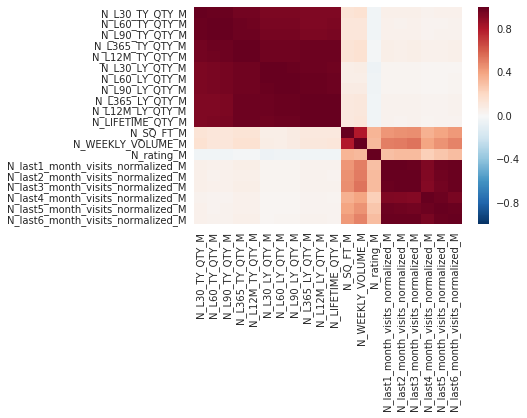

In [45]:
cols = ['N_L30_TY_QTY_M', 'N_L60_TY_QTY_M', 'N_L90_TY_QTY_M',
       'N_L365_TY_QTY_M', 'N_L12M_TY_QTY_M', 'N_L30_LY_QTY_M',
       'N_L60_LY_QTY_M', 'N_L90_LY_QTY_M', 'N_L365_LY_QTY_M',
       'N_L12M_LY_QTY_M', 'N_LIFETIME_QTY_M', 'N_SQ_FT_M',
       'N_WEEKLY_VOLUME_M', 'N_rating_M',
       'N_last1_month_visits_normalized_M',
       'N_last2_month_visits_normalized_M',
       'N_last3_month_visits_normalized_M',
       'N_last4_month_visits_normalized_M',
       'N_last5_month_visits_normalized_M',
       'N_last6_month_visits_normalized_M']
corr_heat(data_off,cols)

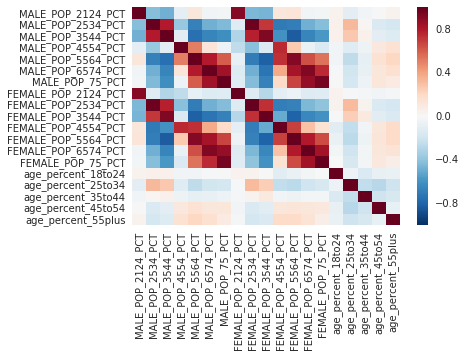

In [46]:
cols = ['MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT',
        'age_percent_18to24', 'age_percent_25to34', 'age_percent_35to44',
       'age_percent_45to54', 'age_percent_55plus']
corr_heat(data_off,cols)

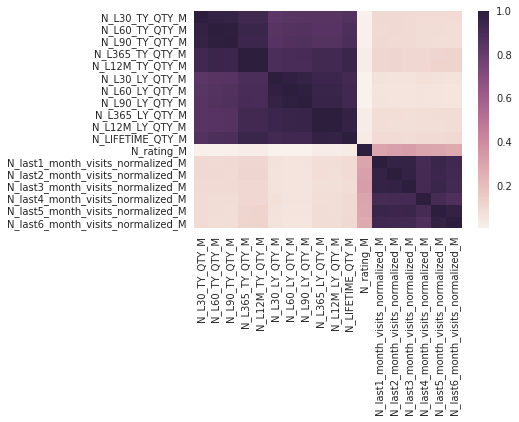

In [47]:
cols = ['N_L30_TY_QTY_M', 'N_L60_TY_QTY_M', 'N_L90_TY_QTY_M',
       'N_L365_TY_QTY_M', 'N_L12M_TY_QTY_M', 'N_L30_LY_QTY_M',
       'N_L60_LY_QTY_M', 'N_L90_LY_QTY_M', 'N_L365_LY_QTY_M',
       'N_L12M_LY_QTY_M', 'N_LIFETIME_QTY_M', 'N_rating_M',
       'N_last1_month_visits_normalized_M',
       'N_last2_month_visits_normalized_M',
       'N_last3_month_visits_normalized_M',
       'N_last4_month_visits_normalized_M',
       'N_last5_month_visits_normalized_M',
       'N_last6_month_visits_normalized_M']
corr_heat(data_on,cols)

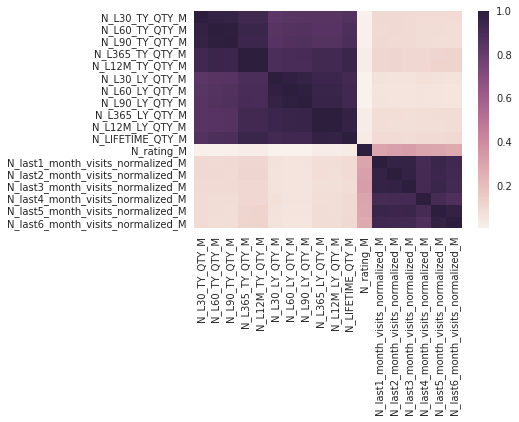

In [48]:
corr_heat(data_on,cols)

# Clustering

In [49]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, Birch, DBSCAN, FeatureAgglomeration, KMeans, MiniBatchKMeans, MeanShift, SpectralClustering
from sklearn import metrics
import itertools
import numpy as np

In [50]:
x_var_on = ['WHITE_POP_PCT', 'BLACK_POP_PCT',
       'ASIAN_POP_PCT', 'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT',
       'BI_CULTURAL_HISP_POP_PCT', 'MOST_ACC_HISP_POP_PCT',
       'OTHER_POP_PCT', 'INCOME_POP_L10_PCT', 'INCOME_POP_1020_PCT',
       'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT', 'INCOME_POP_4050_PCT',
       'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT','gender_percent_male',
       'gender_percent_female', 'age_percent_lessthan18',
       'age_percent_18to24', 'age_percent_25to34', 'age_percent_35to44',
       'age_percent_45to54', 'age_percent_55plus',
       'dayofweek_percent_monday', 'dayofweek_percent_tuesday',
       'dayofweek_percent_wednesday', 'dayofweek_percent_thursday',
       'dayofweek_percent_friday', 'dayofweek_percent_saturday',
       'dayofweek_percent_sunday','B_CHANNEL_DSC_BAR/NIGHTCLUB', 'B_CHANNEL_DSC_DINING',
       'B_CHANNEL_DSC_EXTENDED MASTER ON-PREMISE', 'B_CHANNEL_DSC_LODGING',
       'B_CHANNEL_DSC_RECREATION', 'B_NO_OF_STORES_DSC_1 STORE',
       'B_NO_OF_STORES_DSC_101-200 STORES',
       'B_NO_OF_STORES_DSC_11-25 STORES', 'B_NO_OF_STORES_DSC_2-3 STORES',
       'B_NO_OF_STORES_DSC_201-500 STORES',
       'B_NO_OF_STORES_DSC_26-50 STORES', 'B_NO_OF_STORES_DSC_4-5 STORES',
       'B_NO_OF_STORES_DSC_501+ STORES',
       'B_NO_OF_STORES_DSC_51-100 STORES',
       'B_NO_OF_STORES_DSC_6-10 STORES',
       'B_NIELSEN_SIZE_DSC_20K=85K HOUSEHOLDS',
       'B_NIELSEN_SIZE_DSC_URBAN (LARGEST 21 METROS)',
       'B_NIELSEN_SIZE_DSC_URBAN ALL OTHER COUNTIES',
       'B_drinks_cocktails_f', 'B_drinks_cocktails_t', 'B_drinks_beer_f',
       'B_drinks_beer_t', 'B_drinks_wine_f', 'B_drinks_wine_t',
       'B_drinks_serveshappyhour_f', 'B_drinks_serveshappyhour_t',
       'N_L30_TY_QTY_M', 'N_L60_TY_QTY_M', 'N_L90_TY_QTY_M',
       'N_L365_TY_QTY_M', 'N_L12M_TY_QTY_M', 'N_L30_LY_QTY_M',
       'N_L60_LY_QTY_M', 'N_L90_LY_QTY_M', 'N_L365_LY_QTY_M',
       'N_L12M_LY_QTY_M', 'N_LIFETIME_QTY_M', 'N_rating_M',
       'N_last1_month_visits_normalized_M',
       'N_last2_month_visits_normalized_M',
       'N_last3_month_visits_normalized_M',
       'N_last4_month_visits_normalized_M',
       'N_last5_month_visits_normalized_M',
       'N_last6_month_visits_normalized_M']


In [52]:
param = {'KMeans':{'model':KMeans(),
                  'n_clusters':[3,5,11,15,21,27,35,43],
                  'n_jobs':[-2]},
        'DBSCAN':{'model':DBSCAN(),
                  'eps':[0.2,0.3,0.4,0.5], 
                  'min_samples':[5,10,20,40,80],
                  'n_jobs':[-2]},
        'BIRCH':{'model':DBSCAN(),
                'threshold':[0.1,0.2,0.3,0.4,0.5]}
        }
opt_model_on = cluster_GridSearch(data_on[x_var_on],param,metric_name = 'Silhouette',verbose = True)

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.2}
Silhouette: -0.442856635734

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.3}
Silhouette: -0.243564691584

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.4}
Silhouette: 0.13397665163

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.5}
Silhouette: 0.267713260047

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.2}
Silhouette: nan

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.3}
Silhouette: -0.217049140901

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.4}
Silhouette: 0.0916869311049

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.5}
Silhouette: 0.221979450739

Model: DBSCAN
Parameters: {'min_samples': 20, 'n_jobs': -2, 'eps': 0.2}
Silhouette: nan

Model: DBSCAN
Parameters: {'min_samples': 20, 'n_jobs': -2, 'eps': 0.3}
Silhouette: -0.210456122314

Model: DBSCAN
Paramete

In [54]:
x_var_off = ['WHITE_POP_PCT', 'BLACK_POP_PCT',
       'ASIAN_POP_PCT', 'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT',
       'BI_CULTURAL_HISP_POP_PCT', 'MOST_ACC_HISP_POP_PCT',
       'OTHER_POP_PCT', 'INCOME_POP_L10_PCT', 'INCOME_POP_1020_PCT',
       'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT', 'INCOME_POP_4050_PCT',
       'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT','gender_percent_male',
       'gender_percent_female', 'age_percent_lessthan18',
       'age_percent_18to24', 'age_percent_25to34', 'age_percent_35to44',
       'age_percent_45to54', 'age_percent_55plus',
       'dayofweek_percent_monday', 'dayofweek_percent_tuesday',
       'dayofweek_percent_wednesday', 'dayofweek_percent_thursday',
       'dayofweek_percent_friday', 'dayofweek_percent_saturday',
       'dayofweek_percent_sunday','B_CHANNEL_DSC_CATEGORY KILLER', 'B_CHANNEL_DSC_CIGARETTE OUTLET',
       'B_CHANNEL_DSC_CONVENIENCE STORE', 'B_CHANNEL_DSC_DRUG',
       'B_CHANNEL_DSC_GROCERY', 'B_CHANNEL_DSC_LIQUOR',
       'B_CHANNEL_DSC_MASS MERCHANDISER', 'B_CHANNEL_DSC_WHOLESALE CLUB',
       'B_NO_OF_STORES_DSC_1 STORE', 'B_NO_OF_STORES_DSC_101-200 STORES',
       'B_NO_OF_STORES_DSC_11-25 STORES', 'B_NO_OF_STORES_DSC_2-3 STORES',
       'B_NO_OF_STORES_DSC_201-500 STORES',
       'B_NO_OF_STORES_DSC_26-50 STORES', 'B_NO_OF_STORES_DSC_4-5 STORES',
       'B_NO_OF_STORES_DSC_501+ STORES',
       'B_NO_OF_STORES_DSC_51-100 STORES',
       'B_NO_OF_STORES_DSC_6-10 STORES', 'B_ANNUAL_ACV_DSC_$1 TO $500,000',
       'B_ANNUAL_ACV_DSC_$1,000,001 TO $1,500,000',
       'B_ANNUAL_ACV_DSC_$1,500,001 TO $2,000,000',
       'B_ANNUAL_ACV_DSC_$100,000,001 AND ABOVE',
       'B_ANNUAL_ACV_DSC_$12,000,001 TO $16,000,000',
       'B_ANNUAL_ACV_DSC_$16,000,001 TO $20,000,000',
       'B_ANNUAL_ACV_DSC_$2,000,001 TO $4,000,000',
       'B_ANNUAL_ACV_DSC_$20,000,001 TO $25,000,000',
       'B_ANNUAL_ACV_DSC_$25,000,001 TO $30,000,000',
       'B_ANNUAL_ACV_DSC_$30,000,001 TO $35,000,000',
       'B_ANNUAL_ACV_DSC_$35,000,001 TO $40,000,000',
       'B_ANNUAL_ACV_DSC_$4,000,001 TO $6,000,000',
       'B_ANNUAL_ACV_DSC_$40,000,001 TO $45,000,000',
       'B_ANNUAL_ACV_DSC_$45,000,001 TO $50,000,000',
       'B_ANNUAL_ACV_DSC_$50,000,001 TO $75,000,000',
       'B_ANNUAL_ACV_DSC_$500,001 TO $1,000,000',
       'B_ANNUAL_ACV_DSC_$6,000,001 TO $8,000,000',
       'B_ANNUAL_ACV_DSC_$8,000,001 TO $12,000,000',
       'B_ANNUAL_ACV_DSC_UNKNOWN', 'B_NIELSEN_SIZE_DSC_20K=85K HOUSEHOLDS',
       'B_NIELSEN_SIZE_DSC_URBAN (LARGEST 21 METROS)',
       'B_drinks_cocktails_f', 'B_drinks_cocktails_t', 'B_drinks_beer_f',
       'B_drinks_beer_t', 'B_drinks_wine_f', 'B_drinks_wine_t',
       'B_drinks_serveshappyhour_f', 'B_drinks_serveshappyhour_t',
       'N_L30_TY_QTY_M', 'N_L60_TY_QTY_M', 'N_L90_TY_QTY_M',
       'N_L365_TY_QTY_M', 'N_L12M_TY_QTY_M', 'N_L30_LY_QTY_M',
       'N_L60_LY_QTY_M', 'N_L90_LY_QTY_M', 'N_L365_LY_QTY_M',
       'N_L12M_LY_QTY_M', 'N_LIFETIME_QTY_M', 'N_SQ_FT_M',
       'N_WEEKLY_VOLUME_M', 'N_rating_M',
       'N_last1_month_visits_normalized_M',
       'N_last2_month_visits_normalized_M',
       'N_last3_month_visits_normalized_M',
       'N_last4_month_visits_normalized_M',
       'N_last5_month_visits_normalized_M',
       'N_last6_month_visits_normalized_M']


In [55]:
param = {'KMeans':{'model':KMeans(),
                  'n_clusters':[3,5,11,15,21,27,35,43],
                  'n_jobs':[-2]},
        'DBSCAN':{'model':DBSCAN(),
                  'eps':[0.2,0.3,0.4,0.5], 
                  'min_samples':[5,10,20,40,80],
                  'n_jobs':[-2]},
        'BIRCH':{'model':DBSCAN(),
                'threshold':[0.1,0.2,0.3,0.4,0.5]}
        }
opt_model_on = cluster_GridSearch(data_off[x_var_off],param,metric_name = 'Silhouette',verbose = True)

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.2}
Silhouette: -0.0883401635011

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.3}
Silhouette: -0.00534159338249

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.4}
Silhouette: -0.100071656936

Model: DBSCAN
Parameters: {'min_samples': 5, 'n_jobs': -2, 'eps': 0.5}
Silhouette: 0.00757746660346

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.2}
Silhouette: nan

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.3}
Silhouette: 0.0208626567118

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.4}
Silhouette: 0.0540177310446

Model: DBSCAN
Parameters: {'min_samples': 10, 'n_jobs': -2, 'eps': 0.5}
Silhouette: -0.0482894195428

Model: DBSCAN
Parameters: {'min_samples': 20, 'n_jobs': -2, 'eps': 0.2}
Silhouette: nan

Model: DBSCAN
Parameters: {'min_samples': 20, 'n_jobs': -2, 'eps': 0.3}
Silhouette: -0.0179446311352

Model: DBSCA

In [ ]:

#TODO - ADD VISUALS

# SVD